RNN numba package
=================



## notebook settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/dual_data/bin/python

## Continuous Bump Attractor Model



### imports



In [1]:
import sys
sys.path.insert(0, '/home/leon/tmp/rnn_numba') # put here the path to the repo
from src.model.rate_model import Network

### Single trial



#### Simulation



To run a simulation, first we need to define a network model.
The class Network takes two arguments:

1.  the name of the configuration file that defines the model. 
    This file is well detailed (check config<sub>bump.yml</sub> or config<sub>EI.yml</sub>)
2.  the name of the output file that will contain the simulation data.
    The model writes all relevant data to a single dataframe stored in an h5 format



In [1]:
REPO_ROOT = "/home/leon/tmp/rnn_numba"
model = Network('config_bump.yml', 'bump', REPO_ROOT, VERBOSE=1)

Loading config from /home/leon/tmp/rnn_numba/conf/config_bump.yml
Saving data to /home/leon/tmp/rnn_numba/data/simul/bump.h5
Jab [[-2.75]]
Tuning, KAPPA [0.4]
Asymmetry, SIGMA [0.]
Iext [14.]

Then one just runs the model with



In [1]:
model.run()

#+begin_example
  Generating matrix Cij
  all to all connectivity
  with cosine structure
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Parameters:
  N 1000 Na [1000] K 1.0 Ka [1.]
  Iext [14.] Jab [-2.75]
  Tuning, KAPPA [0.4]
  Asymmetry, SIGMA [0.]
  MF Rates: [5.09090909]
  Transfert Func Sigmoid
  Running simulation
  times (s) 0.5 rates (Hz) [2.18]
  times (s) 1.0 rates (Hz) [2.19]
  STIM ON
  times (s) 1.5 rates (Hz) [6.25]
  STIM OFF
  times (s) 2.0 rates (Hz) [5.9]
  times (s) 2.5 rates (Hz) [5.91]
  times (s) 3.0 rates (Hz) [5.87]
  times (s) 3.5 rates (Hz) [5.87]
  times (s) 4.0 rates (Hz) [5.89]
  saving data to /home/leon/tmp/rnn_numba/data/simul/bump.h5
  Elapsed (with compilation) = 7.23014812899055s
#+end_example

#### Analysis



##### Imports



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump

##### Load data



In [1]:
df = pd.read_hdf(REPO_ROOT + "/data/simul/bump.h5", mode="r")  
print(df.head())

rates         ff       h_E  neurons   time
0  2.512678 -11.005349 -5.810748        0  0.499
1  1.003620  -0.271863 -5.810921        1  0.499
2  4.395283   4.921598 -5.811103        2  0.499
3  1.868867  -2.958338 -5.811292        3  0.499
4  2.314441  -5.003102 -5.811489        4  0.499

##### Rates



###### raster



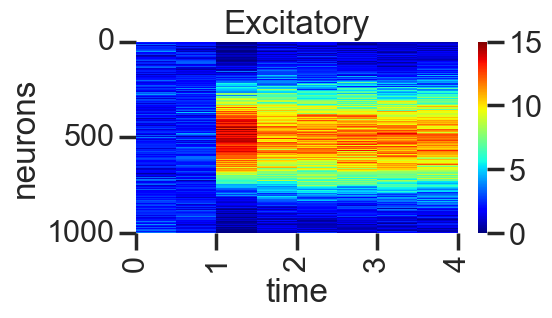

In [1]:
fig, ax = plt.subplots()
pt = pd.pivot_table(df, values="rates", index=["neurons"], columns="time")

sns.heatmap(pt, cmap="jet", ax=ax, vmax=15, vmin=0)
ax.set_yticks([0, 500, 1000], [0, 500, 1000])
ax.set_xticks([0, 2, 4, 6, 8], [0, 1, 2, 3, 4])
ax.set_title('Excitatory')

plt.show()

###### histograms



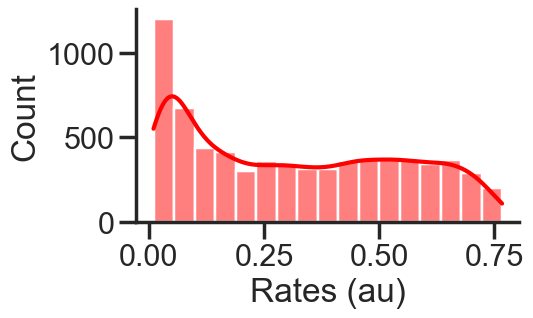

In [1]:
mean_df = df.groupby("neurons").mean()
mean_df[mean_df.rates<.01] = np.nan

sns.histplot(mean_df_E, x=mean_df_E.rates, kde=True, color='r')
plt.xlabel("Rates (au)")
plt.show()

##### Tuning



In [1]:
data = df.groupby(['time'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])

print(data.head())

time        m0        m1     phase
0  0.499  2.182644  0.170818  0.151626
1  0.999  2.189366  0.052484  2.583821
2  1.499  6.248643  7.171486  3.136531
3  1.999  5.900416  5.401989  3.128763
4  2.499  5.910800  5.532978  3.094187

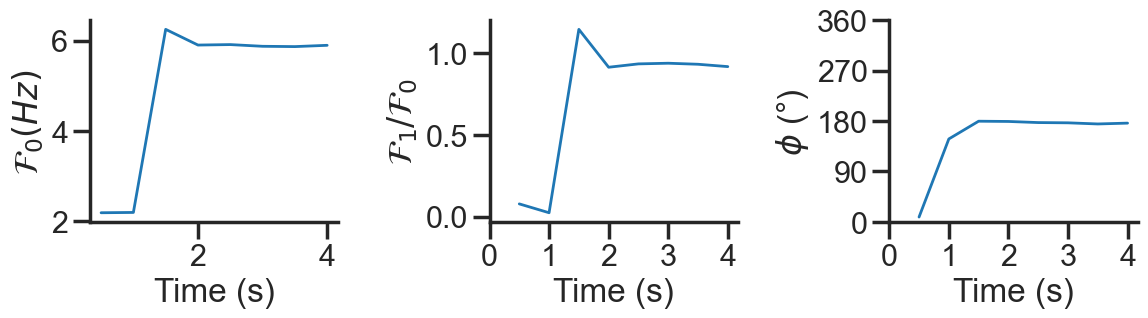

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y='m0', legend=False, lw=2, ax=ax[0])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\mathcal{F}_0 (Hz)$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['m1']/data['m0'], legend=False, lw=2, ax=ax[1])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[2])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('$\phi$ (°)')
ax[2].set_xticks([0, 1, 2, 3, 4])
ax[2].set_yticks([0, 90, 180, 270, 360])
plt.show()

### Multiple trials



#### Simulations



In [1]:
ini_list = np.arange(1, 10)

REPO_ROOT = "/home/leon/tmp/rnn_numba"

IF_LOAD_MAT = 0
IF_SAVE_MAT = 1

for ini in ini_list:
    print('##########################################')
    print("trial", ini)
    print('##########################################')

    model = Network('config_EI.yml', 'bump_ini_%d' % ini, REPO_ROOT,
                    IF_LOAD_MAT=IF_LOAD_MAT, IF_SAVE_MAT=IF_SAVE_MAT)

    model.run()

    IF_LOAD_MAT = 1
    IF_SAVE_MAT = 0

#+begin_example
  ##########################################
  trial 1
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_ini_1.h5
  Generating matrix Cij
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 53.97293146402808s
  ##########################################
  trial 2
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_ini_2.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 56.96205114200711s
  ##########################################
  trial 3
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bu

#### Analysis



##### Imports



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump

##### Load data



In [1]:
ini_list = np.arange(1, 10)

df_list = []

for ini in ini_list:
    df_i = pd.read_hdf(REPO_ROOT + "/data/simul/bump_ini_%d.h5" % ini, mode="r")
    df_i['trial'] = ini
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
print(df.head())

rates         ff       h_E        h_I  neurons   time  trial
0  0.620963  17.178619  7.837148 -24.014507        0  0.499      1
1  0.348972  19.188986  8.049864 -25.528297        1  0.499      1
2  0.044523  18.140488  8.291198 -27.459217        2  0.499      1
3  0.051996  17.061010  7.774259 -26.545981        3  0.499      1
4  0.396972  16.060816  8.087732 -25.197549        4  0.499      1

In [1]:
data = df.groupby(['time', 'trial'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])
print(data.head())

time  trial        m0        m1     phase
0  0.499      1  0.310010  0.436322  1.350543
1  0.499      2  0.309471  0.435234  1.345035
2  0.499      3  0.309075  0.434342  1.501287
3  0.499      4  0.308214  0.433595  1.501947
4  0.499      5  0.309797  0.435703  1.300236

In [1]:
end_point = data[data.time == data.time.iloc[-1]]
print(end_point.head())

time  trial        m0        m1     phase
63  3.999      1  0.305413  0.429020  2.379814
64  3.999      2  0.306242  0.430313  2.387125
65  3.999      3  0.305628  0.429620  2.393247
66  3.999      4  0.304745  0.428685  2.389969
67  3.999      5  0.305512  0.429292  2.385865

##### Phases



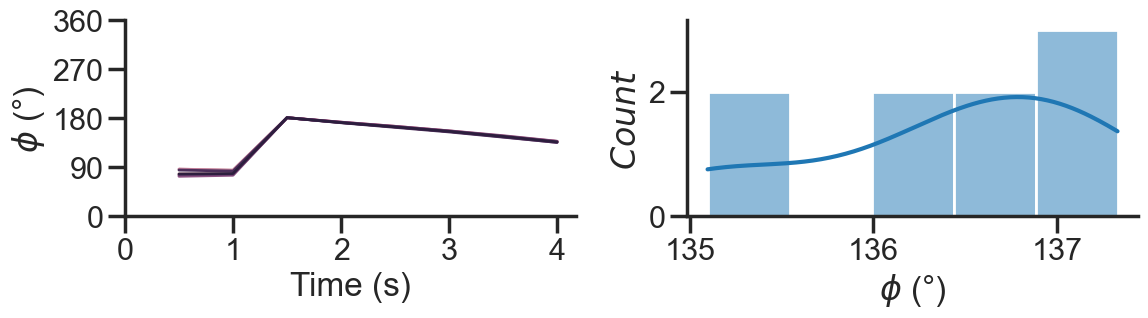

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[0], hue='trial')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\phi$ (°)')
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_yticks([0, 90, 180, 270, 360])

sns.histplot(data=end_point, x=end_point['phase']*180/np.pi, legend=False, ax=ax[1], bins='auto', kde=True)
ax[1].set_xlabel('$\phi$ (°)')
ax[1].set_ylabel('$Count$')
# ax[1].set_xticks([0, 90, 180, 270, 360])
plt.show()

##### Precision Errors



In [1]:
from scipy.stats import circmean
stim_phase = np.pi

end_point['accuracy'] = end_point.phase - stim_phase
end_point['precision'] = end_point.phase - circmean(end_point.phase)
print(end_point.head())

#+begin_example
       time  trial        m0        m1     phase  accuracy  precision
  63  3.999      1  0.305413  0.429020  2.379814 -0.761779  -0.000976
  64  3.999      2  0.306242  0.430313  2.387125 -0.754468   0.006335
  65  3.999      3  0.305628  0.429620  2.393247 -0.748345   0.012458
  66  3.999      4  0.304745  0.428685  2.389969 -0.751623   0.009180
  67  3.999      5  0.305512  0.429292  2.385865 -0.755728   0.005076
  /tmp/ipykernel_2966984/1857574883.py:4: SettingWithCopyWarning: 
  A value is trying to be set on a copy of a slice from a DataFrame.
  Try using .loc[row_indexer,col_indexer] = value instead

  See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    end_point['accuracy'] = end_point.phase - stim_phase
  /tmp/ipykernel_2966984/1857574883.py:5: SettingWithCopyWarning: 
  A value is trying to be set on a copy of a slice from a DataFrame.
  Try using .loc[row_indexer,col_in

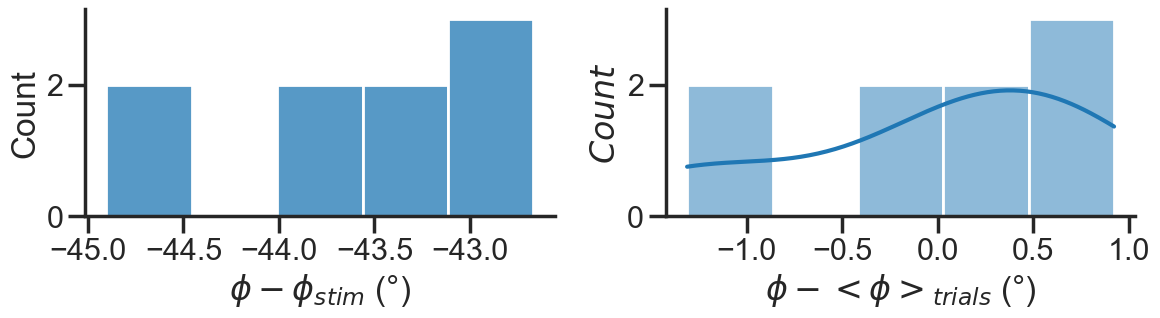

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.histplot(data=end_point, x=end_point['accuracy']*180/np.pi, legend=False, lw=2, ax=ax[0])
ax[0].set_xlabel('$\phi - \phi_{stim}$ (°)')
ax[0].set_ylabel('Count')

sns.histplot(data=end_point, x=end_point['precision']*180/np.pi, legend=False, ax=ax[1], bins='auto', kde=True)
ax[1].set_xlabel('$\phi - <\phi>_{trials}$ (°)')
ax[1].set_ylabel('$Count$')

plt.show()

## Balanced EI Bump Attractor Model



### imports



In [1]:
import sys
sys.path.insert(0, '/home/leon/tmp/rnn_numba') # put here the path to the repo
from src.model.rate_model import Network

### Single trial



#### Simulation



To run a simulation, first we need to define a network model.
The class Network takes two arguments:

1.  the name of the configuration file that defines the model. 
    This file is well detailed (check config<sub>bump.yml</sub> or config<sub>EI.yml</sub>)
2.  the name of the output file that will contain the simulation data.
    The model writes all relevant data to a single dataframe stored in an h5 format



In [1]:
REPO_ROOT = "/home/leon/tmp/rnn_numba"
model = Network('config_EI.yml', 'bump', REPO_ROOT, VERBOSE=1 , M0=1)

Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
Saving data to /home/leon/tmp/rnn_numba/data/simul/bump.h5
Jab [[ 1.  -1.5]
 [ 1.  -1. ]]
Tuning, KAPPA [5. 0. 0. 0.]
Asymmetry, SIGMA [0. 0. 0. 0.]
Iext [0.5  0.25]

Then one just runs the model with



In [1]:
model.run()

#+begin_example
  Generating matrix Cij
  sparse connectivity
  with spec cosine structure
  sparse connectivity
  sparse connectivity
  sparse connectivity
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Parameters:
  N 10000 Na [7500 2500] K 500.0 Ka [500. 500.]
  Iext [11.18033989  5.59016994] Jab [ 0.04472136 -0.06708204  0.04472136 -0.04472136]
  Tuning, KAPPA [5. 0. 0. 0.]
  Asymmetry, SIGMA [0. 0. 0. 0.]
  MF Rates: [0.25 0.5 ]
  Transfert Func Sigmoid
  Running simulation
  times (s) 0.25 rates (Hz) [0.0, 0.29]
  times (s) 0.5 rates (Hz) [0.0, 0.29]
  times (s) 0.75 rates (Hz) [0.0, 0.29]
  times (s) 1.0 rates (Hz) [0.0, 0.29]
  STIM ON
  times (s) 1.25 rates (Hz) [0.54, 0.74]
  times (s) 1.5 rates (Hz) [0.54, 0.74]
  STIM OFF
  times (s) 1.75 rates (Hz) [0.37, 0.6]
  times (s) 2.0 rates (Hz) [0.37, 0.6]
  times (s) 2.25 rates (Hz) [0.37, 0.6]
  times (s) 2.5 rates (Hz) [0.37, 0.6]
  times (s) 2.75 rates (Hz) [0.37, 0.6]
  times (s) 3.0 rates (Hz) [0.37, 0.6]


#### Analysis



##### Imports



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump

##### Load data



In [1]:
df = pd.read_hdf(REPO_ROOT + "/data/simul/bump.h5", mode="r")
df_E = df[df.neurons<7500]
df_I = df[df.neurons>=7500]

print(df.head())

rates        ff           h_E        h_I  neurons   time
0  1.603719e-14 -1.237244  1.555830e-10  -9.824757        0  0.249
1  1.068644e-15 -0.286277  2.175872e-10 -10.012830        1  0.249
2  5.164796e-14  1.380938  3.022810e-10  -9.672483        2  0.249
3  2.162490e-15  0.181033  7.054538e-11  -9.582123        3  0.249
4  1.895197e-13  0.603522  2.518099e-10  -9.404711        4  0.249

##### Rates



###### raster



In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
pt = pd.pivot_table(df, values="rates", index=["neurons"], columns="time")

sns.heatmap(pt[:7500], cmap="jet", ax=ax[0], vmax=1, vmin=0)
ax[0].set_yticks([0, 2500, 5000, 7500], [0, 2500, 5000, 7500])
ax[0].set_xticks([0, 2, 4, 6, 8], [0, 1, 2, 3, 4])
ax[0].set_title('Excitatory')

sns.heatmap(pt[7500:], cmap="jet", ax=ax[1], vmax=1, vmin=0)
ax[1].set_yticks([0, 625, 1250, 1875, 2500], [0, 625, 1250, 1875, 2500])
ax[1].set_xticks([0, 2, 4, 6, 8], [0, 1, 2, 3, 4])
ax[1].set_title('Inhibitory')

plt.show()

###### histograms



In [1]:
mean_df_E = df_E.groupby("neurons").mean()
mean_df_E[mean_df_E.rates<.01] = np.nan

mean_df_I = df_I.groupby("neurons").mean()
mean_df_I[mean_df_I.rates<.01] = np.nan

sns.histplot(mean_df_E, x=mean_df_E.rates, kde=True, color='r', label='E')
sns.histplot(mean_df_I, x=mean_df_I.rates, kde=True, color='b', label='I')
plt.legend(fontsize=12)
plt.xlabel("Rates (au)")
plt.show()

##### Tuning



In [1]:
data = df_E.groupby(['time'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])

print(data.head())

time            m0            m1     phase
0  0.249  1.971564e-11  1.996778e-11  4.101198
1  0.499  9.912278e-12  3.949440e-12  0.031584
2  0.749  8.105434e-11  1.410955e-10  4.814738
3  0.999  7.173168e-12  3.755936e-12  0.843219
4  1.249  5.370993e-01  5.969055e-01  3.144594

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y='m0', legend=False, lw=2, ax=ax[0])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\mathcal{F}_0 (Hz)$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['m1']/data['m0'], legend=False, lw=2, ax=ax[1])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[2])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('$\phi$ (°)')
ax[2].set_xticks([0, 1, 2, 3, 4])
ax[2].set_yticks([0, 90, 180, 270, 360])
plt.show()

#### Parameter search



In [1]:
Ie_list = np.linspace(0.1, 1, 10)
print(Ie_list)

REPO_ROOT = "/home/leon/tmp/rnn_numba"

IF_LOAD_MAT = 0
IF_SAVE_MAT = 1

for Ie in Ie_list:
    print('##########################################')
    print("Ie", Ie)
    print('##########################################')

    model = Network('config_EI.yml', 'bump_Ie_%.1f' % Ie, REPO_ROOT,
                    IF_LOAD_MAT=IF_LOAD_MAT, IF_SAVE_MAT=IF_SAVE_MAT,
                    Gain=Ie)

    model.run()

    IF_LOAD_MAT = 1
    IF_SAVE_MAT = 0

#+begin_example
  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
  ##########################################
  Ie 0.1
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_Ie_0.1.h5
  Generating matrix Cij
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 57.59470825298922s
  ##########################################
  Ie 0.2
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_Ie_0.2.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 58.72569092398044s
  ##########################################
  Ie 0.30000000000000004
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.

In [1]:
Ie_list = np.linspace(0.1, 1.0, 10)

df_list = []

for i in range(Ie_list.shape[0]):
    df_i = pd.read_hdf(REPO_ROOT + "/data/simul/bump_Ie_%.1f.h5" % Ie_list[i], mode="r")
    df_i['Ie'] = i
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
df_E = df[df.neurons<7500]
print(df.head())

rates         ff       h_E        h_I  neurons   time  Ie
0  0.368926  12.781403  9.071170 -20.381302        0  0.249   0
1  0.548235  12.137876  8.606775 -19.757314        1  0.249   0
2  0.791355  12.516987  8.236397 -18.628502        2  0.249   0
3  0.659268  10.232158  8.340149 -19.042084        3  0.249   0
4  0.235941   8.420432  8.426077 -20.439227        4  0.249   0

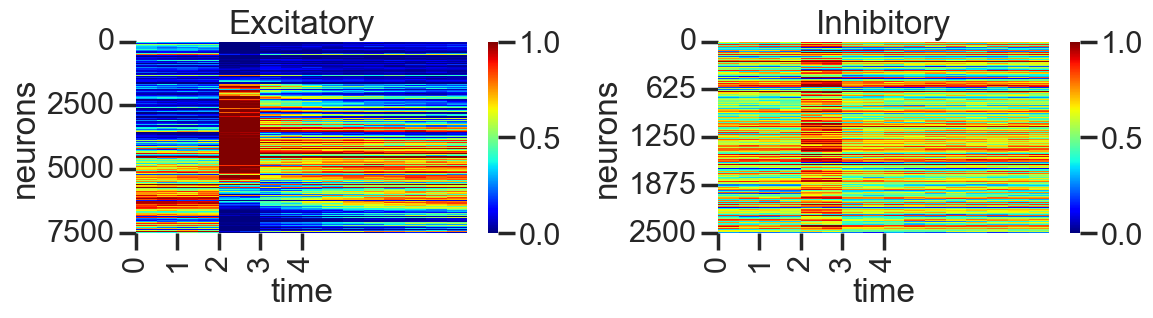

In [1]:
trial = 0
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
pt = pd.pivot_table(df[df.Ie==trial], values="rates", index=["neurons"], columns="time")

sns.heatmap(pt[:7500], cmap="jet", ax=ax[0], vmax=1, vmin=0)
ax[0].set_yticks([0, 2500, 5000, 7500], [0, 2500, 5000, 7500])
ax[0].set_xticks([0, 2, 4, 6, 8], [0, 1, 2, 3, 4])
ax[0].set_title('Excitatory')

sns.heatmap(pt[7500:], cmap="jet", ax=ax[1], vmax=1, vmin=0)
ax[1].set_yticks([0, 625, 1250, 1875, 2500], [0, 625, 1250, 1875, 2500])
ax[1].set_xticks([0, 2, 4, 6, 8], [0, 1, 2, 3, 4])
ax[1].set_title('Inhibitory')

plt.show()

### Multiple trials



#### Simulations



In [1]:
ini_list = np.arange(1, 10)

REPO_ROOT = "/home/leon/tmp/rnn_numba"

IF_LOAD_MAT = 0
IF_SAVE_MAT = 1

for ini in ini_list:
    print('##########################################')
    print("trial", ini)
    print('##########################################')

    model = Network('config_EI.yml', 'bump_ini_%d' % ini, REPO_ROOT,
                    IF_LOAD_MAT=IF_LOAD_MAT, IF_SAVE_MAT=IF_SAVE_MAT)

    model.run()

    IF_LOAD_MAT = 1
    IF_SAVE_MAT = 0

#+begin_example
  ##########################################
  trial 1
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_ini_1.h5
  Generating matrix Cij
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 53.97293146402808s
  ##########################################
  trial 2
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bump_ini_2.h5
  Loading matrix from /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Running simulation
  Elapsed (with compilation) = 56.96205114200711s
  ##########################################
  trial 3
  ##########################################
  Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
  Saving data to /home/leon/tmp/rnn_numba/data/simul/bu

#### Analysis



##### Imports



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump

##### Load data



In [1]:
ini_list = np.arange(1, 10)

df_list = []

for ini in ini_list:
    df_i = pd.read_hdf(REPO_ROOT + "/data/simul/bump_ini_%d.h5" % ini, mode="r")
    df_i['trial'] = ini
    df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
df_E = df[df.neurons<7500]
print(df.head())

rates         ff       h_E        h_I  neurons   time  trial
0  0.620963  17.178619  7.837148 -24.014507        0  0.499      1
1  0.348972  19.188986  8.049864 -25.528297        1  0.499      1
2  0.044523  18.140488  8.291198 -27.459217        2  0.499      1
3  0.051996  17.061010  7.774259 -26.545981        3  0.499      1
4  0.396972  16.060816  8.087732 -25.197549        4  0.499      1

In [1]:
data = df_E.groupby(['time', 'trial'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])
print(data.head())

time  trial        m0        m1     phase
0  0.499      1  0.310010  0.436322  1.350543
1  0.499      2  0.309471  0.435234  1.345035
2  0.499      3  0.309075  0.434342  1.501287
3  0.499      4  0.308214  0.433595  1.501947
4  0.499      5  0.309797  0.435703  1.300236

In [1]:
end_point = data[data.time == data.time.iloc[-1]]
print(end_point.head())

time  trial        m0        m1     phase
63  3.999      1  0.305413  0.429020  2.379814
64  3.999      2  0.306242  0.430313  2.387125
65  3.999      3  0.305628  0.429620  2.393247
66  3.999      4  0.304745  0.428685  2.389969
67  3.999      5  0.305512  0.429292  2.385865

##### Phases



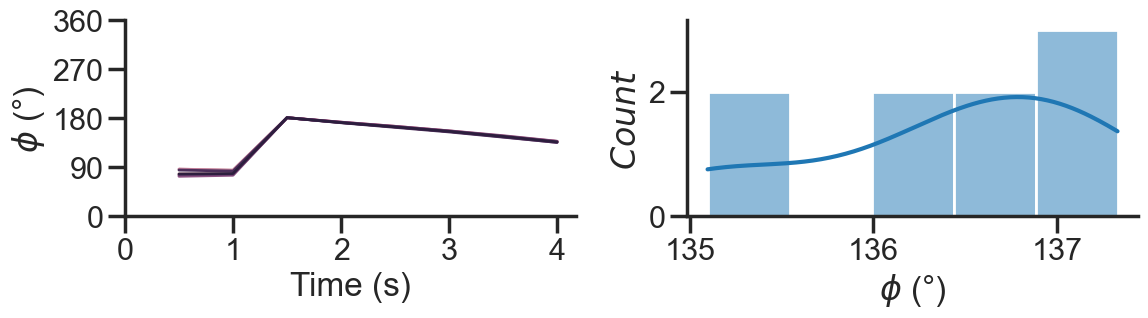

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[0], hue='trial')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\phi$ (°)')
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_yticks([0, 90, 180, 270, 360])

sns.histplot(data=end_point, x=end_point['phase']*180/np.pi, legend=False, ax=ax[1], bins='auto', kde=True)
ax[1].set_xlabel('$\phi$ (°)')
ax[1].set_ylabel('$Count$')
# ax[1].set_xticks([0, 90, 180, 270, 360])
plt.show()

##### Precision Errors



In [1]:
from scipy.stats import circmean
stim_phase = np.pi

end_point['accuracy'] = end_point.phase - stim_phase
end_point['precision'] = end_point.phase - circmean(end_point.phase)
print(end_point.head())

#+begin_example
       time  trial        m0        m1     phase  accuracy  precision
  63  3.999      1  0.305413  0.429020  2.379814 -0.761779  -0.000976
  64  3.999      2  0.306242  0.430313  2.387125 -0.754468   0.006335
  65  3.999      3  0.305628  0.429620  2.393247 -0.748345   0.012458
  66  3.999      4  0.304745  0.428685  2.389969 -0.751623   0.009180
  67  3.999      5  0.305512  0.429292  2.385865 -0.755728   0.005076
  /tmp/ipykernel_2966984/1857574883.py:4: SettingWithCopyWarning: 
  A value is trying to be set on a copy of a slice from a DataFrame.
  Try using .loc[row_indexer,col_indexer] = value instead

  See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    end_point['accuracy'] = end_point.phase - stim_phase
  /tmp/ipykernel_2966984/1857574883.py:5: SettingWithCopyWarning: 
  A value is trying to be set on a copy of a slice from a DataFrame.
  Try using .loc[row_indexer,col_in

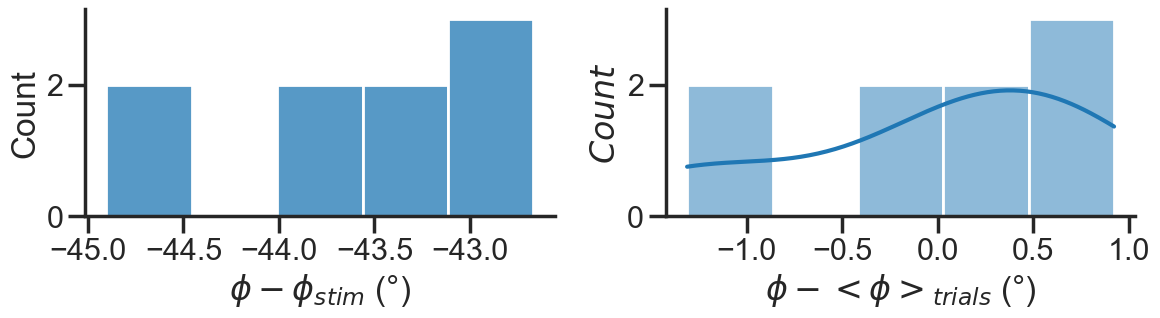

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

sns.histplot(data=end_point, x=end_point['accuracy']*180/np.pi, legend=False, lw=2, ax=ax[0])
ax[0].set_xlabel('$\phi - \phi_{stim}$ (°)')
ax[0].set_ylabel('Count')

sns.histplot(data=end_point, x=end_point['precision']*180/np.pi, legend=False, ax=ax[1], bins='auto', kde=True)
ax[1].set_xlabel('$\phi - <\phi>_{trials}$ (°)')
ax[1].set_ylabel('$Count$')

plt.show()